In [1]:

import random
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


class Linac:
    """The Linac class is for linac objects. 
    """

    def __init__(self, number_linacs=1, hours=10, slots_per_hour=3):
        """Constructor for new patient object.
        """
        self.number_linacs = number_linacs
        self.hours = hours
        self.slots_per_hour = slots_per_hour
        # slots on machines 
        self.max = int(self.number_linacs*self.hours*self.slots_per_hour)
        
        self.empty_slots = []
        self.fractions_left = [0]*self.max
        self.queue = []

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
linacs = 6
treatment_hours = 9
slots_per_hour = 3

capacity  = 100
treatment_hours = treatment_hours*(capacity/100)

linac = Linac(linacs,treatment_hours,slots_per_hour)



In [3]:
df = pd.read_excel('Prioritisation Categories COVID 19.xlsx', header = 1)

# drop rows if empty cells in column
df = df.dropna(subset=['Date TRF Submitted'])
# get np.array of headers
qaz = df.columns.values
# set the 6th header
qaz[5] ='location'
# replace th headers
df.columns = qaz

# select based on location
df1 = df[df['location'] == 'SJH']
df2 = df[df['location'] == 'BH']
df3 = df[df['location'] == 'SLH']

# make a completely new dataframe
df4 = pd.DataFrame(df3.values, columns = df3.columns)
# format the date into a proper datetime object
df4['Date TRF Submitted'] = pd.to_datetime( df4['Date TRF Submitted'], format='%d.%m.%y')

df5 = df4['Suggested Priority'].copy()

df4['Suggested Priority'].where(~np.array(['LP' in i for i in df5]) ,3, inplace = True)
df4['Suggested Priority'].where(~np.array(['MP' in i for i in df5]) ,2, inplace = True)
df4['Suggested Priority'].where(~np.array(['HP' in i for i in df5]) ,1, inplace = True)

# remove columns not interested in
df4.drop(df4.columns[[1, 5, 7, 8]], axis = 1, inplace = True) 
# not interested in these either
df4.drop(['PALL', 'Radical'], axis =1, inplace=True)

################################################## PALLIATIVE decision
# keep only priority 1,2 patients
# df4 = df4[df4['Suggested Priority'] != 3]

# rename columns to simply labels
df4.columns = ['date', 'priority', 'fractions']

# determine a dataframe of the days since referral
days = pd.DataFrame([(pd.Timestamp.today()-i).days for i in df4.date])

# insert days column into out main dataframe
df4.insert(1,'days', days.values, True)

In [4]:
def new_priority(priority, days):
    if priority == 1:
        weight = 1/priority + (days/20)
    elif priority == 2:
        if days > 19:
            # the - 30th ensures cat 1 patients on same day remain weighted higher
            weight = 1 + days/20 - 1/30
        else:
            weight = -0.5 + np.exp(days*np.log(2.5)/20)
    elif priority == 3:
        weight = 1/priority + (days/60)
    
    return weight

np_priority  = np.vectorize(new_priority)

In [5]:
weight = np_priority(df4.priority, df4.days)

# insert weight column into our main dataframe
df4.insert(2,'weight', weight, True)
# sort by weight and fractions
df4.sort_values(by=['weight', 'fractions'], ascending=[False,True], inplace=True)
# reset the index of the rows since they get sorted as well
df4 = df4.reset_index(drop=True)



[extension of treatments paper](https://www.sciencedirect.com/science/article/abs/pii/S1507136719300185)

In [6]:
################################ to simulate a gap per patient
## df4.fractions += 1
from scipy.optimize import curve_fit

gaps =np.load('gap_freq.npy')
(a,λ), pcov = curve_fit(lambda days,a,λ: a*np.exp(-λ*days),gaps[:,0]-0.5,gaps[:,1], p0 = (30,0.05))

adder = lambda s1, s2: s1 + s2
df4.fractions = df4.fractions.combine( pd.Series((np.random.exponential(1/λ,df4.shape[0])).astype('int') ), adder )

weekly_intake = [df4]*120

In [8]:
def pop(df, values, axis=1):
    '''
    example
    
    df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6], 'C': [7, 8, 9]},
                  columns=['A', 'B', 'C'])
                  
    pop(df, 0, axis=0)
    
    returns
    
       | A | B | C
     ------------
      0  1   4   7
    
    
    df = 
       | A | B | C
     ------------
      1  2   5   8
      2  3   6   9
    
    
    '''
    if axis == 0:
        if isinstance(values, (list, tuple)):
            popped_rows = df.loc[values]
            df.drop(values, axis=0, inplace=True)
            return popped_rows
        elif isinstance(values, (int)):
            popped_row = df.loc[values].to_frame().T
            df.drop(values, axis=0, inplace=True)
            return popped_row
        else:
            print('values parameter needs to be a list, tuple or int.')
    elif axis == 1:
        # current df.pop(values) logic here
        return df.pop(values)

In [9]:
# loop for a set number of days
# 5 days in a week

# create empty an dataframe
patients = pd.DataFrame(columns = df4.columns)

# loop for a set number of days
for i in np.arange(120): # 120 = 24 weeks ~ 6 months

    if i%5 ==0: # ie if it is a Monday we need to intake a new supple of patients
        patients = pd.concat([patients,weekly_intake[i]])
        patients.sort_values(by=['weight', 'fractions'], ascending=[False,True], inplace=True)
        patients = patients.reset_index(drop=True) # this resets the all the row index labels from zero at the top                
                         
    print(patients.fractions.values.T)  # list of patients awaiting a start on a Monday             

    # count spaces, sort them keeping empty spaces to the left
    if any(np.array(linac.fractions_left) == 0):
        linac.fractions_left=np.sort(linac.fractions_left)
        space = linac.fractions_left.tolist().count(0)
        print('space')
        if i%5 in [0,1]: # added to simulate only Mon,Tues starts
            if space > 0:
                for j in np.arange(space):
                    if patients.shape[0] > 0:
                        k = pop(patients, 0, axis=0) # remove a patient 
                        patients = patients.reset_index(drop=True) # reset index, otherwise 0 index disappears
                        linac.fractions_left[j] = k.fractions # add patient fractions to the linac
        # space left after filling
        space = linac.fractions_left.tolist().count(0)            
    else:
        space = 0
    print(linac.fractions_left)        
    linac.empty_slots.append(space)    
    linac.queue.append(patients.shape[0])
    linac.fractions_left -= np.array([1]) # treat all the fractions, ie subtract 1.
    linac.fractions_left[linac.fractions_left<0] = 0 # if any are negative, return to zero
    
    # increment priority
    if patients.shape[0] > 0:
        patients.days += 1
        weight = np_priority(patients.priority, patients.days)
        patients.weight = weight
        


[5.0 13.0 26.0 33.0 30.0 1.0 5.0 6.0 24.0 25.0 36.0 39.0 24.0 28.0 38.0
 2.0 2.0 39.0 19.0 27.0 30.0 33.0 15.0 39.0 5.0 8.0 18.0 11.0 4.0 16.0
 12.0 29.0 5.0 5.0 6.0 8.0 10.0 10.0]
space
[ 5 13 26 33 30  1  5  6 24 25 36 39 24 28 38  2  2 39 19 27 30 33 15 39
  5  8 18 11  4 16 12 29  5  5  6  8 10 10  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[]
space
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0

[ 5 13 26 33 30  1  5  6 24 25 36 39 24 28 38  2  2 39 19 27 30 33 15 39
  5  8 18 11  4 16 12 29  5  5  6  8 10 10  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  2
  3  3  3  3  4  5  5  5  6  6  7  8  8  9  9  9 10 10 11 11 12 13 13 14
 14 14 14 15 15 15 16 17 18 18 18 19 19 19 20 20 20 21 21 22 23 23 23 23
 24 24 24 24 25 25 26 28 28 28 29 29 29 31 33 34 34 34]
[]
space
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  1  1  2  2  2  2  3  3  4  4  4  4  4
  4  4  4  5  5  5  5  6  7  7  7  7  8  8  8  9  9  9  9 10 10 10 11 11
 12 12 12 13 13 13 13 14 14 14 14 15 15 16 17 17 17 17 18 18 18 18 19 19
 19 20 20 21 22 22 22 22 23 23 23 23 23 23 24 24 24 25 25 26 27 27 27 27
 28 28 28 28 29 29 30 32 32 32 33 33 33 35 37 38 38 38]
[]


[ 5 13 26 33 30  1  5  6 24 25 36 39 24 28 38  2  2 39 19 27 30 33 15 39
  5  8 18 11  4 16 12 29  5  5  6  8 10 10  0  0  0  0  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  2  2  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  5  5  5  5  5  5  6  6  6  6  7  7  8  8  8  8  8  8  9  9  9  9  9
  9  9 10 10 10 10 11 11 11 12 13 13 13 13 13 14 14 14 14 14 14 14 15 15
 15 16 16 17 18 18 18 18 19 19 19 19 19 19 20 20 20 21 21 22 23 23 23 23
 24 24 24 24 25 25 26 28 28 28 29 29 29 31 33 34 34 34]
[]
space
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  2
  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  6  6  7  7  7  7  7  7  7  7  8  8  8  8  8  8
  8  9  9  9  9  9  9 10 10 10 10 11 11 12 12 12 12 12 12 13 13 13 13 13
 13 13 14 14 14 14 15 15 15 16 17 17 17 17 17 18 18 18 18 18 18 18 19 19
 19 20 20 21 22 22 22 22 23 23 23 23 23 23 24 24 24 25 25 26 27 27 27 27
 28 28 28 28 29 29 30 32 32 32 33 33 33 35 37 38 38 38]
[]


[ 5 13 26 33 30  1  5  6 24 25 36 39 24 28 38  2  2 39 19 27 30 33 15 39
  5  8 18 11  4 16 12 29  5  5  6  8 10 10  0  0  0  0  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  2  2  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  5  5  5  5  5  5  6  6  6  6  7  7  8  8  8  8  8  8  9  9  9  9  9
  9  9 10 10 10 10 11 11 11 12 13 13 13 13 13 14 14 14 14 14 14 14 15 15
 15 16 16 17 18 18 18 18 19 19 19 19 19 19 20 20 20 21 21 22 23 23 23 23
 24 24 24 24 25 25 26 28 28 28 29 29 29 31 33 34 34 34]
[]
space
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  2
  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  6  6  7  7  7  7  7  7  7  7  8  8  8  8  8  8
  8  9  9  9  9  9  9 10 10 10 10 11 11 12 12 12 12 12 12 13 13 13 13 13
 13 13 14 14 14 14 15 15 15 16 17 17 17 17 17 18 18 18 18 18 18 18 19 19
 19 20 20 21 22 22 22 22 23 23 23 23 23 23 24 24 24 25 25 26 27 27 27 27
 28 28 28 28 29 29 30 32 32 32 33 33 33 35 37 38 38 38]
[]


[ 5 13 26 33 30  1  5  6 24 25 36 39 24 28 38  2  2 39 19 27 30 33 15 39
  5  8 18 11  4 16 12 29  5  5  6  8 10 10  0  0  0  0  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  2  2  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  5  5  5  5  5  5  6  6  6  6  7  7  8  8  8  8  8  8  9  9  9  9  9
  9  9 10 10 10 10 11 11 11 12 13 13 13 13 13 14 14 14 14 14 14 14 15 15
 15 16 16 17 18 18 18 18 19 19 19 19 19 19 20 20 20 21 21 22 23 23 23 23
 24 24 24 24 25 25 26 28 28 28 29 29 29 31 33 34 34 34]
[]
space
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  2
  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  6  6  7  7  7  7  7  7  7  7  8  8  8  8  8  8
  8  9  9  9  9  9  9 10 10 10 10 11 11 12 12 12 12 12 12 13 13 13 13 13
 13 13 14 14 14 14 15 15 15 16 17 17 17 17 17 18 18 18 18 18 18 18 19 19
 19 20 20 21 22 22 22 22 23 23 23 23 23 23 24 24 24 25 25 26 27 27 27 27
 28 28 28 28 29 29 30 32 32 32 33 33 33 35 37 38 38 38]
[]


[ 5 13 26 33 30  1  5  6 24 25 36 39 24 28 38  2  2 39 19 27 30 33 15 39
  5  8 18 11  4 16 12 29  5  5  6  8 10 10  0  0  0  0  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  2  2  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  5  5  5  5  5  5  6  6  6  6  7  7  8  8  8  8  8  8  9  9  9  9  9
  9  9 10 10 10 10 11 11 11 12 13 13 13 13 13 14 14 14 14 14 14 14 15 15
 15 16 16 17 18 18 18 18 19 19 19 19 19 19 20 20 20 21 21 22 23 23 23 23
 24 24 24 24 25 25 26 28 28 28 29 29 29 31 33 34 34 34]
[]
space
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  2
  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  6  6  7  7  7  7  7  7  7  7  8  8  8  8  8  8
  8  9  9  9  9  9  9 10 10 10 10 11 11 12 12 12 12 12 12 13 13 13 13 13
 13 13 14 14 14 14 15 15 15 16 17 17 17 17 17 18 18 18 18 18 18 18 19 19
 19 20 20 21 22 22 22 22 23 23 23 23 23 23 24 24 24 25 25 26 27 27 27 27
 28 28 28 28 29 29 30 32 32 32 33 33 33 35 37 38 38 38]
[]


[ 5 13 26 33 30  1  5  6 24 25 36 39 24 28 38  2  2 39 19 27 30 33 15 39
  5  8 18 11  4 16 12 29  5  5  6  8 10 10  0  0  0  0  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  2  2  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  5  5  5  5  5  5  6  6  6  6  7  7  8  8  8  8  8  8  9  9  9  9  9
  9  9 10 10 10 10 11 11 11 12 13 13 13 13 13 14 14 14 14 14 14 14 15 15
 15 16 16 17 18 18 18 18 19 19 19 19 19 19 20 20 20 21 21 22 23 23 23 23
 24 24 24 24 25 25 26 28 28 28 29 29 29 31 33 34 34 34]
[]
space
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  2
  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  6  6  7  7  7  7  7  7  7  7  8  8  8  8  8  8
  8  9  9  9  9  9  9 10 10 10 10 11 11 12 12 12 12 12 12 13 13 13 13 13
 13 13 14 14 14 14 15 15 15 16 17 17 17 17 17 18 18 18 18 18 18 18 19 19
 19 20 20 21 22 22 22 22 23 23 23 23 23 23 24 24 24 25 25 26 27 27 27 27
 28 28 28 28 29 29 30 32 32 32 33 33 33 35 37 38 38 38]
[]


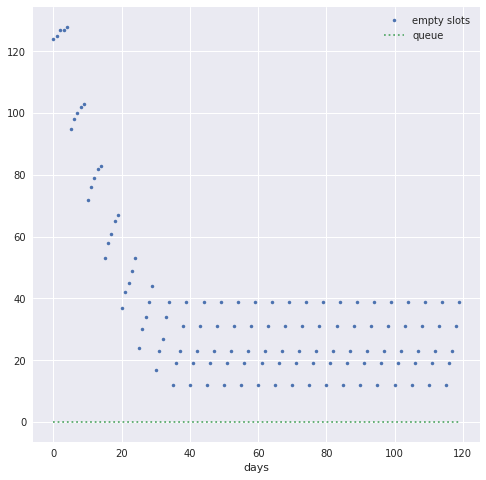

In [10]:
plt.figure(figsize=(8,8))
plt.plot(linac.empty_slots, '.', label='empty slots')

plt.plot(linac.queue, ':', label='queue')
plt.xlabel('days')
plt.legend();